In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score

/home/tomy07417/data-science/ml/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-20 06:37:05.085280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 06:37:05.142451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 06:37:07.679856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slig

In [2]:
df = pd.read_csv("./data/train_with_features.csv")
test = pd.read_csv("./data/test_with_features.csv")

SEED = 42

X_train, X_validation, y_train, y_validation = train_test_split(df[['text', 'sentimiento', 'tiene_url']], df['target'], test_size=0.2, random_state=SEED)
mean_encoder = TargetEncoder(random_state=SEED)
one_hot_encoder = OneHotEncoder()
xgb_model = XGBClassifier(random_state=SEED)
sbert = SentenceTransformer("all-mpnet-base-v2")

In [3]:
def limpiar_texto(texto):
    # Reemplazar URLs por token
    texto = re.sub(r"http\S+|www\S+", " URL ", texto)
    # Reemplazar menciones (@usuario)
    texto = re.sub(r"@\w+", " USER ", texto)   
    # Reemplazar hashtags (dejando la palabra)
    texto = re.sub(r"#(\w+)", r" HASHTAG_\1 ", texto) 
    # Reemplazar emojis (usando su significado textual)
    texto = emoji.demojize(texto, language="en")  # 😊 → :cara_sonriente:
    texto = re.sub(r":([a-zA-Z0-9_]+):", r" EMOJI_\1 ", texto)
    # Eliminar caracteres especiales innecesarios
    texto = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9_\s]", " ", texto) 
    # Pasar a minúsculas
    texto = texto.lower() 
    # Quitar espacios múltiples
    texto = re.sub(r"\s+", " ", texto).strip()
    
    return texto

In [4]:
x_sentimiento = mean_encoder.fit_transform(X_train[['sentimiento']], y_train)
x_url = one_hot_encoder.fit_transform(X_train[['tiene_url']]).toarray()

clean_text =  X_train.text.map(limpiar_texto)
X_emb = sbert.encode(clean_text.tolist(), show_progress_bar=True)

X_encoded = np.hstack((X_emb, x_sentimiento, x_url))

parametros_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'alpha': [0, 0.01, 0.1, 1, 10],
    'lambda': [0.01, 0.1, 1, 10],
    'objective': ['binary:logistic']
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=parametros_xgb,
    n_iter=15,
    scoring='f1',
    cv=3,
    random_state=SEED,
    n_jobs=-1
)

Batches: 100%|██████████| 191/191 [00:12<00:00, 15.84it/s]


In [ ]:
random_search_xgb.fit(X_encoded, y_train)

In [ ]:
x_sentimiento_val = mean_encoder.transform(X_validation[['sentimiento']])
x_url_val = one_hot_encoder.transform(X_validation[['tiene_url']]).toarray()

clean_text_val =  X_validation.text.map(limpiar_texto)
x_emb_val = sbert.encode(clean_text_val.tolist(), show_progress_bar=True)

x_encoded_val = np.hstack((x_emb_val, x_sentimiento_val, x_url_val))
y_pred_val = random_search_xgb.predict(x_encoded_val)

accuracy_score(y_validation, y_pred_val)

Batches: 100%|██████████| 48/48 [00:03<00:00, 13.65it/s]


0.8332239001969797

In [ ]:
f1_score(y_validation, y_pred_val)

0.7934959349593496

In [ ]:
x_sentimiento_test = mean_encoder.transform(test[['sentimiento']])
x_url_test = one_hot_encoder.transform(test[['tiene_url']]).toarray()

clean_text_test = test.text.map(limpiar_texto)
x_emb_test = sbert.encode(clean_text_test.tolist(), show_progress_bar=True)

x_encoded_test = np.hstack((x_emb_test, x_sentimiento_test, x_url_test))
y_pred_test = random_search_xgb.predict(x_encoded_test)

Batches: 100%|██████████| 102/102 [00:06<00:00, 16.86it/s]


In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'target': y_pred_test
})
submission.to_csv('./submission/xgb_sbert_submission.csv', index=False)

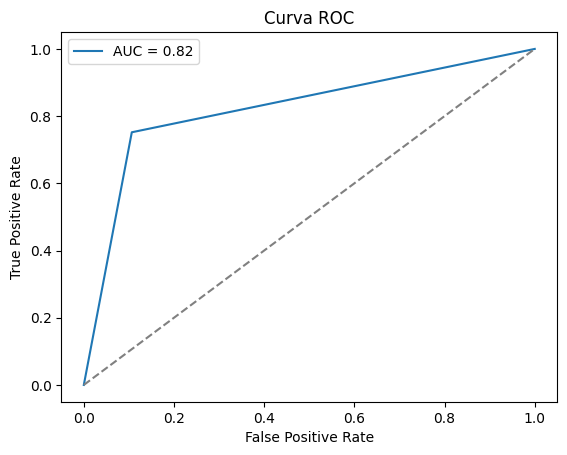

In [ ]:
fpr, tpr, _ = roc_curve(y_validation, y_pred_val)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_validation, y_pred_val):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

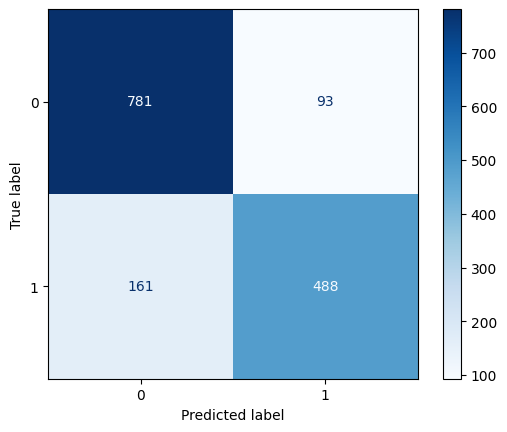

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay(confusion_matrix(y_validation, y_pred_val)).plot(cmap='Blues')
plt.show()